In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from i import svg_dir, data_dir, model_dir, submissions_dir, model_pred_train_dir, model_pred_test_dir
from i import FeaturesToNumericalPipeline
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.pipeline import Pipeline

from gplearn.genetic import SymbolicTransformer, SymbolicClassifier

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# gpt = joblib.load(model_dir + "gpt.joblib")
# gpc = joblib.load(model_dir + "gpc.joblib")

train = pd.read_csv(data_dir + "train.csv", index_col=0)
test = pd.read_csv(data_dir + "test.csv", index_col=0)

for col in train.select_dtypes(include="object").columns:
            train[col] = train[col].astype("category")
for col in test.select_dtypes(include="object").columns:
            test[col] = test[col].astype("category")

y = train.iloc[:, -1]
X = train.iloc[:, :-1]
X_pred = test

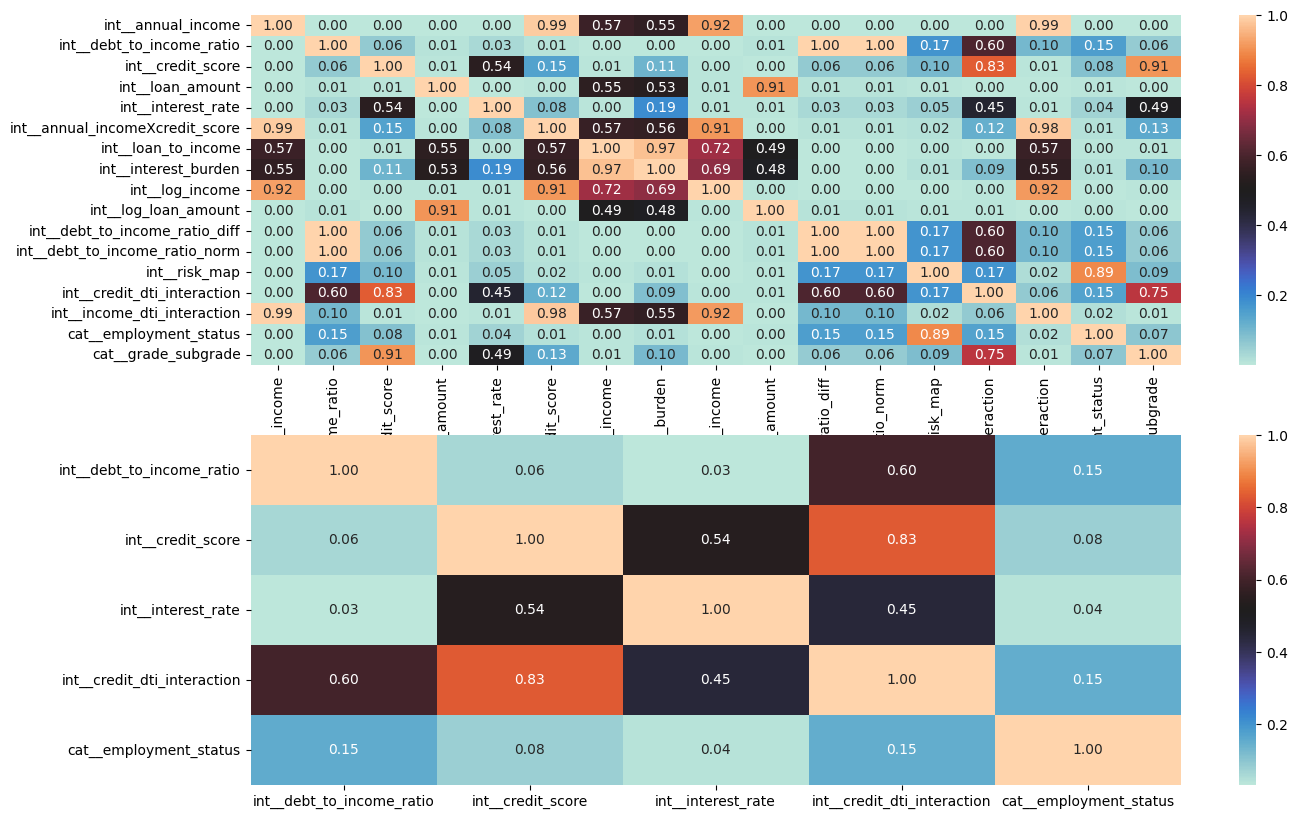

In [2]:
X_heat = FeaturesToNumericalPipeline.fit_transform(X, y)
corr = X_heat.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [c for c in upper.columns if any(upper[c] > 0.9)]
X_reduced = X_heat.drop(columns=to_drop)
corr_target = X_reduced.corrwith(y).abs()
selected_columns = corr_target[(corr_target > 0.05) & (corr_target < 0.6)].index
X_gp = X_reduced[selected_columns]
corr2 = X_gp.corr().abs()

fig, ax = plt.subplots(2, 1, figsize=(15, 10))
sns.heatmap(corr, cmap="icefire", annot=True, fmt="0.2f", ax=ax[0])
sns.heatmap(corr2, cmap="icefire", annot=True, fmt="0.2f", ax=ax[1])
fig.savefig(svg_dir + "heatmap.svg")
plt.show()

In [3]:
gpt = Pipeline(
    [
        ("features", FeaturesToNumericalPipeline.set_params(selector__columns=selected_columns)),
        (
            "gpt",
            SymbolicTransformer(
                generations=20,  # number of evolution cycles
                population_size=2000,  # number of candidate formulas
                hall_of_fame=100,  # keep best 50 formulas
                n_components=10,  # how many new features to produce
                function_set=("add", "sub", "mul", "div", "sqrt", "log", "abs", "sin", "cos"),
                feature_names=selected_columns,
                parsimony_coefficient=0.00001,  # penalty for overly complex formulas
                max_samples=0.9,
                random_state=42,
                verbose=1,
                n_jobs=-1,
            ),
        ),
    ]
)

gpt.fit(X, y)
joblib.dump(gpt, model_dir + "gpt.joblib")

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    10.39         0.281598       18         0.656262         0.656172     36.19m
   1     9.37         0.488573       39         0.692182          0.68765     31.51m
   2    12.31         0.531539       32         0.700189         0.703855     32.89m
   3    21.48         0.550324       14         0.703196         0.703282     41.38m
   4    29.31         0.569112       32         0.710137         0.712462     45.50m
   5    32.15          0.59108       36         0.710714         0.709943     38.97m
   6    33.75         0.612784       28         0.710943         0.708823     38.77m
   7    33.45         0.626802       69         0.712196         0.716112     37.32m
   8    34.38         0.624521       75         0.713455         0.709301  

['C:/Users/Blanc/DataScientist/Kaggle/PlayGround/S5E11/kaggle/working/model/gpt.joblib']

In [ ]:
gpc = Pipeline(
    [
        ("features", FeaturesToNumericalPipeline.set_params(selector__columns=selected_columns)),
        (
            "gpc",
            SymbolicClassifier(
                generations=20,  # number of evolution cycles
                population_size=2000,  # number of candidate formulas
                function_set=("add", "sub", "mul", "div", "sqrt", "log", "abs", "sin", "cos"),
                feature_names=selected_columns,
                parsimony_coefficient=0.00001,  # penalty for overly complex formulas
                max_samples=0.9,
                random_state=42,
                verbose=1,
                n_jobs=7,
            ),
        ),
    ]
)

# score_gpc = cross_val_score(gpc, X_gp, y, cv=cv, scoring="roc_auc")
# print(f"gpc scores across folds: {score_gpc} - Mean Score: {score_gpc.mean():0.4f}")

gpc.fit(X, y)
joblib.dump(gpc, model_dir + "gpc.joblib")

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    10.39         0.875273       18          0.30479         0.306276     32.10m
   1    11.62         0.642453       18          0.30467         0.307355     31.94m
   2    19.55         0.677602       37         0.297547         0.294425     38.77m
   3    21.78         0.669189       20          0.28705         0.286028     36.80m
   4    22.30         0.563503       18         0.280235         0.278671     32.87m
   5    23.71         0.529084       16         0.275735           0.2775     31.48m
   6    27.29         0.519899       16         0.276189         0.273421     32.31m
   7    31.27         0.512329       45         0.269885         0.269605     32.56m
   8    26.18         0.529241       37         0.268392         0.269645  

['C:/Users/Blanc/DataScientist/Kaggle/PlayGround/S5E11/kaggle/working/model/gpc.joblib']

In [11]:
[f"GP_{c}" for c in range(10)]

['GP_0',
 'GP_1',
 'GP_2',
 'GP_3',
 'GP_4',
 'GP_5',
 'GP_6',
 'GP_7',
 'GP_8',
 'GP_9']

In [12]:
train_gp = pd.DataFrame(data=gpt.transform(X), index=X.index, columns=[f"GP_{c}" for c in range(10)])
test_gp = pd.DataFrame(data=gpt.transform(X_pred), index=X_pred.index, columns=[f"GP_{c}" for c in range(10)])

train_gp.to_parquet(data_dir + "train_gp.parquet")
test_gp.to_parquet(data_dir + "test_gp.parquet")

In [8]:
prediction = pd.DataFrame(
  data={
    "loan_paid_back": gpc.predict(X_pred)
  },
  index=X_pred.index
)
probability_train = pd.DataFrame(
  data={
    "loan_paid_back_probability_GP": cross_val_predict(gpc, X, y, cv=cv, method="predict_proba")[:, 1]
  },
  index=X.index
)
probability_test = pd.DataFrame(
  data={
    "loan_paid_back_probability_GP": gpc.predict_proba(X_pred)[:, 1]
  },
  index=X_pred.index
)

prediction.to_parquet(submissions_dir + "submission_gp.parquet")
probability_train.to_parquet(model_pred_train_dir + "train_prob_gp.parquet")
probability_test.to_parquet(model_pred_test_dir + "test_prob_gp.parquet")

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    10.39         0.874918       18         0.302624         0.305659     26.86m
   1    11.64         0.640296       18         0.302454         0.307188     24.65m
   2    19.85         0.669016       37         0.296417         0.291971     29.91m
   3    21.85         0.675525       23         0.278264         0.279226     28.29m
   4    22.23         0.569059       17         0.275545         0.279721     24.95m
   5    24.80          0.50039       29         0.272745         0.271455     24.72m
   6    30.26         0.474894       29         0.271958         0.278539     26.36m
   7    32.57         0.463391       35         0.270092         0.267881     26.37m
   8    30.27         0.493583       30         0.268816         0.268721  